In [2]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math
import pandas as pd
from sklearn import preprocessing
import pickle

In [3]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [4]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [2000])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [2000])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

In [5]:
@time_func
def SVM_RFE_W_STEP(step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, sampling_p = 0.5, dstep_p = 0.1, dstop = 1):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.sampling_percentagee = sampling_p
    data.dstep_percentage = dstep_p
    data.dstop = dstop
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_combo, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))

    print(kernel, C, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time, (np.mean(all_scores), err)

rbf 1.0 0.1


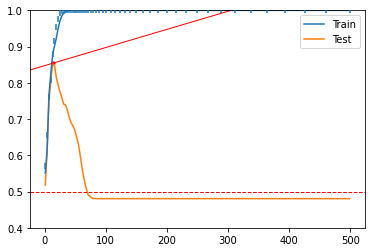

AT (13, 0.8539986329460013, 0.12200109364319896) WITH 52 ITERATIONS IN 25.107429129736765 SECONDS : 0.37066721740964853
__main__.SVM_RFE_W_STEP - 00:00:40.938245500


((13, 0.8539986329460013, 0.12200109364319896),
 25.107429129736765,
 (0.11828699721331302, 0.004905161193608587))

In [11]:
SVM_RFE_W_STEP(kernel='rbf', gamma=0.1,  C=1.0,  dstop=20, dstep_p=0.08, sampling_p=0.2, step=3)

rbf 1.1 0.1


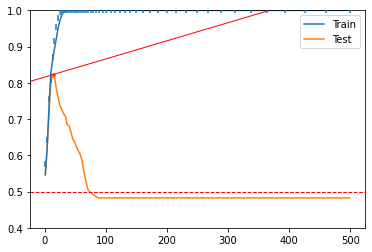

AT (13, 0.8224915435441751, 0.14720676516465994) WITH 52 ITERATIONS IN 24.632736376353673 SECONDS : 0.05545717677990774
__main__.SVM_RFE_W_STEP - 00:00:39.816456100


((13, 0.8224915435441751, 0.14720676516465994),
 24.632736376353673,
 (0.1383504004767163, 0.009358094643108843))

In [12]:
SVM_RFE_W_STEP(kernel='rbf', gamma=0.1,  C=1.1,  dstop=20, dstep_p=0.08, sampling_p=0.2, step=3)

rbf 1.1 0.01


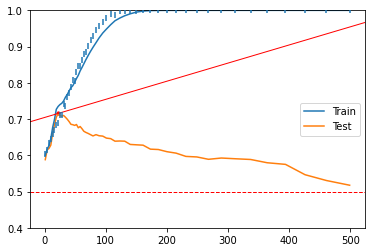

AT (22, 0.7155178155178155, 0.23638574758574765) WITH 52 ITERATIONS IN 24.605856009892054 SECONDS : 0.2719124886454424
__main__.SVM_RFE_W_STEP - 00:00:40.453464600
rbf 1.1 0.025


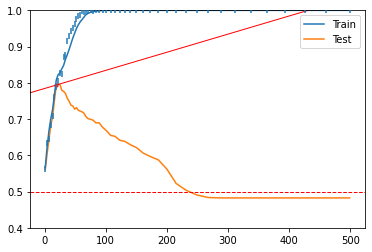

AT (19, 0.7939761992393571, 0.1724190406085143) WITH 52 ITERATIONS IN 27.619781528200424 SECONDS : 0.202617372085138
__main__.SVM_RFE_W_STEP - 00:00:45.528549100
rbf 1.1 0.05


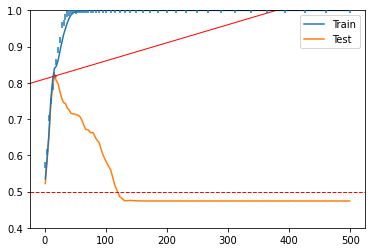

AT (16, 0.8185270869481396, 0.15157833044148833) WITH 52 ITERATIONS IN 31.416641099112375 SECONDS : 0.08913619925372548
__main__.SVM_RFE_W_STEP - 00:00:48.675341700
rbf 1.1 0.1


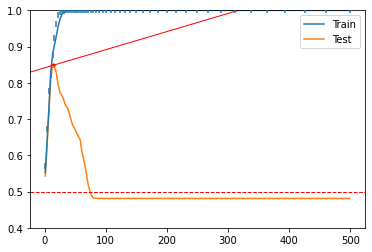

AT (13, 0.8479941111520058, 0.12680471107839533) WITH 52 ITERATIONS IN 28.673992565699987 SECONDS : 0.03403685242005386
__main__.SVM_RFE_W_STEP - 00:00:44.735216500
rbf 1.1 0.2


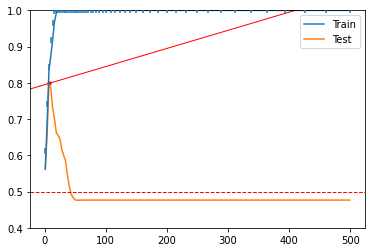

AT (7, 0.7984576826682089, 0.16403385386543287) WITH 52 ITERATIONS IN 28.24892292703901 SECONDS : 0.08147558297040011
__main__.SVM_RFE_W_STEP - 00:00:44.292016600
rbf 1.1 0.3


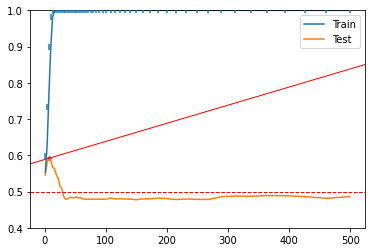

AT (7, 0.5919448972080551, 0.32924408223355595) WITH 52 ITERATIONS IN 28.93923340524946 SECONDS : 0.2229656503179554
__main__.SVM_RFE_W_STEP - 00:00:45.273332000


In [16]:
model_selection = {}
for gamma in [0.010, 0.025, 0.05, 0.1, 0.2, 0.3]:
    for C in [1.1]:
        model_selection[C, gamma] = SVM_RFE_W_STEP(kernel='rbf', gamma=gamma,  C=C,  dstop=20, dstep_p=0.08, sampling_p=0.2, step=3)

In [15]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.010: 1, 0.025: 2, 0.05: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f} $\\pm$ {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[2][0], v[2][1])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1.0} &    25 & 71.70\% & 0.228 $\pm$ 0.008 &    19 & 79.60\% & 0.168 $\pm$ 0.010 &    16 & 81.40\% & 0.153 $\pm$ 0.010\\


In [15]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '', '', '', '', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>2s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 100)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} & 0:20.24 & 0:20.80 & 0:20.75 & 0:24.10 & 0:21.58 & 0:21.40 & 0:21.68 & 0:21.64 & 0:20.16\\
\textbf{0.2} & 0:20.66 & 0:20.78 & 0:20.65 & 0:24.01 & 0:21.97 & 0:21.31 & 0:21.44 & 0:22.25 & 0:20.15\\
\textbf{0.3} & 0:21.37 & 0:20.61 & 0:20.76 & 0:22.29 & 0:21.52 & 0:21.93 & 0:21.98 & 0:22.16 & 0:21.79\\
\textbf{0.4} & 0:19.71 & 0:21.18 & 0:20.76 & 0:21.30 & 0:22.64 & 0:21.73 & 0:21.62 & 0:21.83 & 0:22.00\\
\textbf{0.5} & 0:19.89 & 0:20.43 & 0:21.56 & 0:21.47 & 0:21.46 & 0:21.54 & 0:21.61 & 0:21.87 & 0:22.03\\
\textbf{0.6} & 0:19.09 & 0:20.13 & 0:20.42 & 0:21.08 & 0:21.39 & 0:21.83 & 0:21.82 & 0:22.03 & 0:22.24\\
\textbf{0.7} & 0:19.19 & 0:20.02 & 0:20.83 & 0:21.64 & 0:21.06 & 0:21.61 & 0:21.79 & 0:22.34 & 0:22.05\\
\textbf{0.8} & 0:19.49 & 0:19.76 & 0:20.97 & 0:21.09 & 0:21.26 & 0:21.62 & 0:21.33 & 0:21.73 & 0:21.92\\
\textbf{0.9} & 0:19.49 & 0:19.73 & 0:20.39 & 0:21.22 & 0:21.49 & 0:22.12 & 0:21.39 & 0:22.16 & 0:23.06\\


In [12]:
with open('dump2.pickle', 'wb') as filehandler:
    pickle.dump(model_selection, filehandler)